In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# model
from tensorflow.keras.models import Model
# layers
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import Embedding, Conv1D

# text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# additional imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-03-17 14:54:51--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.005s  

2020-03-17 14:54:51 (93.0 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [0]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# simply remove the last 3 unnamed columns and create a binary labels
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df.columns = ['labels', 'data']
df['b_labels'] = df['labels'].map(lambda l: 1 if l == 'spam' else 0)
# Assign targets
Y = df['b_labels'].values
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [0]:
# split up the data 
df_train, df_test, y_train, y_test = train_test_split(df['data'], Y, test_size = .33)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test) 

In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx) # number of unique tokens 
print("There's {} unique tokens ".format(V))

There's 7261 unique tokens 


In [10]:
# add the padding to the sequences
data_train = pad_sequences(sequences_train) # we have a NxT matrix now
print('The shape of the train tensor: ', data_train.shape)
T = data_train.shape[1] # Sequence length (T)

The shape of the train tensor:  (3733, 189)


In [11]:
data_test = pad_sequences(sequences_test, maxlen = T)
print('The shape of the test tesnor: ', data_test.shape)

The shape of the test tesnor:  (1839, 189)


In [12]:
# Create the model

D = 20

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

cnn = Model(i, x)

cnn.compile(loss = 'binary_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']
            )

r_cnn = cnn.fit(data_train, y_train, validation_data = (data_test, y_test), epochs = 10)

Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 3s 849us/sample - loss: 0.3913 - accuracy: 0.8663 - val_loss: 0.3113 - val_accuracy: 0.8651
Epoch 2/10
3733/3733 [==============================] - 1s 264us/sample - loss: 0.1547 - accuracy: 0.9362 - val_loss: 0.0597 - val_accuracy: 0.9837
Epoch 3/10
3733/3733 [==============================] - 1s 242us/sample - loss: 0.0231 - accuracy: 0.9936 - val_loss: 0.0593 - val_accuracy: 0.9859
Epoch 4/10
3733/3733 [==============================] - 1s 243us/sample - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0577 - val_accuracy: 0.9848
Epoch 5/10
3733/3733 [==============================] - 1s 242us/sample - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.0725 - val_accuracy: 0.9848
Epoch 6/10
3733/3733 [==============================] - 1s 237us/sample - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0852 - val_accuracy: 0.9848
Epoch 7/10
3733/3733 [==============================] - 1s 244us

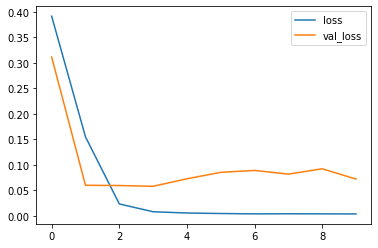

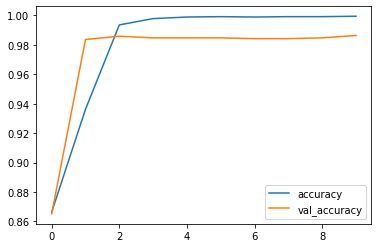

In [13]:
# Plot the loss and accuracy per iteration
# loss
plt.plot(r_cnn.history['loss'], label = 'loss')
plt.plot(r_cnn.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

# accuracy
plt.plot(r_cnn.history['accuracy'], label = 'accuracy')
plt.plot(r_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [14]:
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 20)           145240    
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 43, 128)           24704 

In [15]:
# Let's look at some misclassified examples
preds = np.round(cnn.predict(data_test).reshape(1, -1)[0])
print(preds, preds.shape)

[0. 0. 0. ... 0. 0. 1.] (1839,)


In [17]:
misclassified_idx = np.where(preds != y_test)[0]
print('Total number of misclassifications: ', len(misclassified_idx))
rn = np.random.choice(misclassified_idx)
print('Labeled {} but actual label is {} | 1 for spams and 0 for normal e-mails \n'.format(preds[rn], y_test[rn]))
print(df_test.iloc[rn])

Total number of misclassifications:  25
Labeled 0.0 but actual label is 1 | 1 for spams and 0 for normal e-mails 

Sorry! U can not unsubscribe yet. THE MOB offer package has a min term of 54 weeks> pls resubmit request after expiry. Reply THEMOB HELP 4 more info
